In [19]:
import os

# os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
# os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
from POSEIDON.utility import read_high_res_data_deprecate
import numpy as np
from scipy import constants
from numba import jit
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.constants import R_J, M_J
import numpy as np
import matplotlib.pyplot as plt

In [64]:
from POSEIDON.core import define_model, wl_grid_constant_R


R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 0.118 * R_s  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data_deprecate

# ***** Define model *****#

model_name = "Fe Cr Mg Madhu injection"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe", "Cr"]

high_res_params = ["K_p", "V_sys", "W_conv", "log_alpha"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="gradient",
    high_res_params=high_res_params,
    cloud_model="MacMad17",
    cloud_type="deck",
    # reference_parameter="None",
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.51  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2500  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 50  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Free parameters: ['R_p_ref' 'T_high' 'T_deep' 'log_Fe' 'log_Cr' 'log_P_cloud' 'K_p' 'V_sys'
 'W_conv' 'log_alpha']


In [65]:
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-6, -6]

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([2500, 3500])
log_X_params = np.array([log_species])
cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

param_species = []
log_X_params = np.array([])

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="gradient",
    high_res_params=high_res_params,
    cloud_model="MacMad17",
    cloud_type="deck",
    # reference_parameter="None",
)

atmosphere = make_atmosphere(
    planet, model, P, P_ref, R_p_ref, PT_params, log_X_params, cloud_params
)

# Generate planet surface flux
continuum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

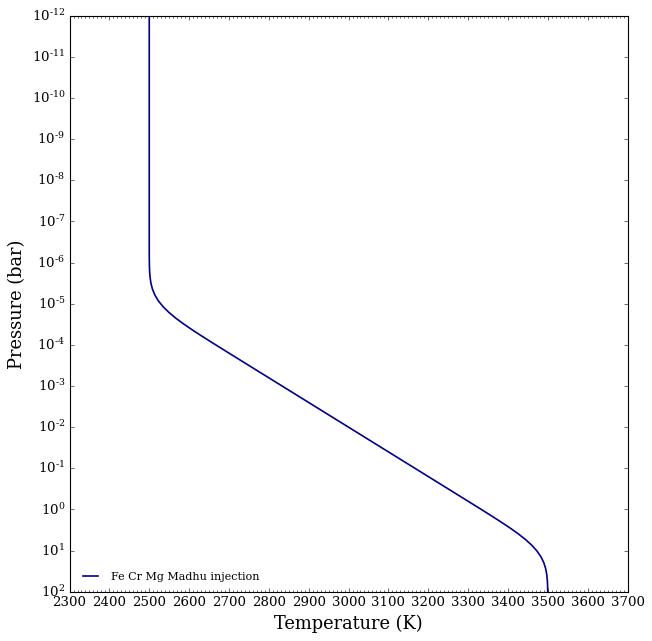

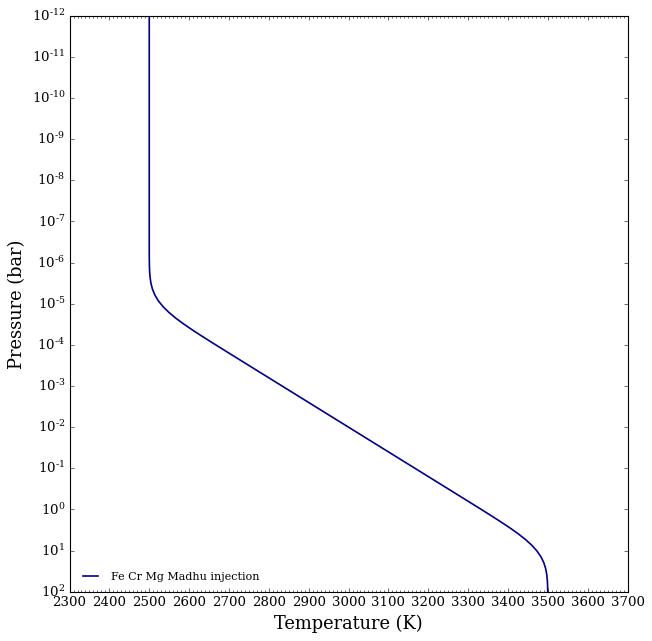

In [66]:
from POSEIDON.visuals import plot_PT

plot_PT(planet, model, atmosphere)

In [68]:
import h5py

with h5py.File("./data/WASP-121b/blue/data_raw.hdf5", "r") as f:
    data = {}
    data["data_raw"] = f["flux"][:]
    data["wl_grid"] = f["wl_grid"][:]
    data["phi"] = f["phi"][:]
    data["transit_weight"] = f["transit_weight"][:]

In [69]:
names = ["Fe_Cr_cloud=0_isotherm"]
inject_dir = "./data/WASP-121b-gradient-injection/"

for name in names:
    make_injection_data(
        data,
        inject_dir,
        name,
        wl,
        spectrum,
        -200,
        -20,
        "sysrem",
        a=3,
        continuum=continuum,
        W_conv=1,
    )

Overwriting data at ./data/WASP-121b-gradient-injection/Fe_Cr_cloud=0_isotherm/data_raw.hdf5
Overwriting data at ./data/WASP-121b-gradient-injection/Fe_Cr_cloud=0_isotherm/data_processed.hdf5
Fitting Poisson uncertainties with 5 components
Blaze correcting data with median filter size 15 and gaussian filter size 50
Filtering out systematics using SYSREM with 15 iterations


In [56]:
from PyAstronomy import pyasl
import POSEIDON

names = ["Fe_Cr_cloud=-2_isotherm"]
data = read_high_res_data(inject_dir, names=names)

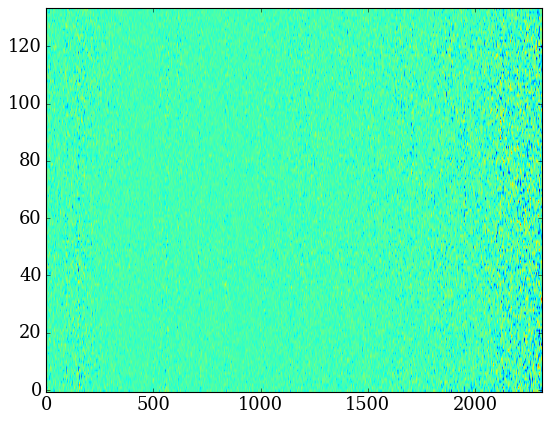

In [57]:
plt.imshow(
    data["Fe_Cr_cloud=-2_isotherm"]["residuals"][0], aspect="auto", origin="lower"
)

In [59]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-500, 501, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # gaussian_filter1d(
        #     spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 400), 100), 3
        # ),
        gaussian_filter1d(spectrum, 1),
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 61.221699476242065 seconds


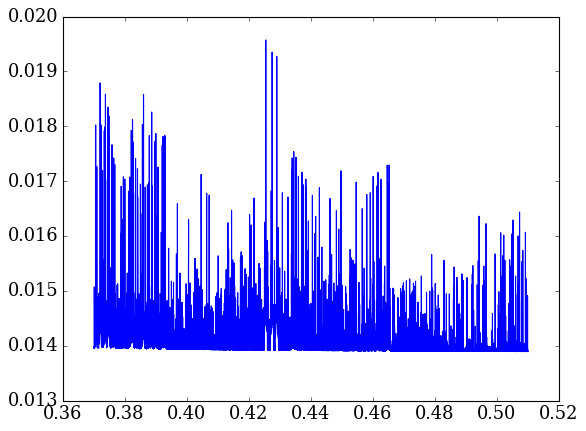

In [62]:
plt.plot(wl, spectrum)

In [ ]:
phi = data["blue"]["phi"]
transit_weight = data["blue"]["transit_weight"]
in_transit = transit_weight != 1
plot_CCF_phase_RV(
    phi[in_transit],
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0)[in_transit],
    "Fe",
    plot_label=False,
    save_path="./CC_output/WASP121_injection_CCF_phase.pdf",
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)